In [69]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<h1>Load data</h1>

In [70]:
file_name = "iris.data.csv"

In [71]:
#load the dataset into memory
dataset = pd.read_csv(file_name,header=None,\
                      names=['sepal_length','sepal_width','petal_length','petal_width','species'])
#check several examples of data
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<h1>Data preprocessing</h1>

In [72]:
#simple function to process the data.
"""
input:
    data: iris dataset
    num_features: 2 => select only petal width and petal width.
                  4 => select all features
    flower: 'Iris-setosa' => labels of Iris-setosa will be 1 and others will be 0
            'Iris-virginica' => labels of Iris-virginica will be 1 and others will be 0
            'None' => use one-hot encoding to represent the labels

return:
    x: normalized & shuffled data
    y: labels
"""
def data_preprocessing(data,num_features,flower=None):
    if num_features==2:
        features = data.columns[2:4]
    else:
        features = data.columns[0:4]
    labels = dataset.columns[4]
    print(features)
    print(labels)
    #normalize the data
    data_norm = pd.DataFrame(data)
    for feature in features:
        data[feature] = (data[feature]-data[feature].mean())/data[feature].std()

    #shuffle the data
    indices = data_norm.index.tolist()
    indices = np.array(indices)
    np.random.shuffle(indices)
    x = data_norm.reindex(indices)[features]
    y = data_norm.reindex(indices)[labels]
    if flower=='Iris-setosa':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-setosa' else 0
        y = y.values.reshape(len(y),1)
    elif flower=='Iris-virginica':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-virginica' else 0
        y = y.values.reshape(len(y),1)
    else:
        y = get_dummies(y)
    return x,y

<h1>Part a:

In [73]:
x_1,y_1 = data_preprocessing(dataset,2,flower='Iris-setosa')
#generate traning and validation sets
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1,y_1,test_size=0.3)
# print(size(x_train_1))
# x_train_1.shape

Index(['petal_length', 'petal_width'], dtype='object')
species


<h2>Define hyper-parameters</h2>

In [74]:
lr = 0.01
num_steps = 500

<h2>Define Placeholder and Variables</h2>

In [75]:
#reset the graph
tf.reset_default_graph()

#define the placeholder to feed the training data later
X = tf.placeholder(tf.float32,shape=[None,2],name='X')
Y = tf.placeholder(tf.float32,shape=[None,1],name='Y')

#define the weights and initialized with random normal distribution
W = tf.Variable(tf.random_normal([2,1]),tf.float32,name='W')
#define the bias with zero initialization
b = tf.Variable(tf.zeros([1,1]),tf.float32,name='b')

<h2>Define update rule and accuracy</h2>

In [76]:
#define the predicted output label
Y_hat = tf.round(tf.sigmoid(tf.add(tf.matmul(X,W),b)))
#the error between target and logit
error = Y-Y_hat


#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(X),error)
db = tf.reduce_sum(error,0)
W_ = W + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(W.assign(W_), b.assign(b_))

# #compare the predicted labels with true labels
# correct_pred = tf.equal(tf.argmax(Y_hat,1),tf.argmax(Y,1))

# #compute the accuracy by taking average
# accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

# #!!!!!!!!!!!!!define loss scalar summary & File Writer!!!!!!!!
# loss_summary = tf.summary.scalar('loss',loss)
# file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

<h2>Execute training</h2>

In [77]:
#initialize tensorflow variables
init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  
#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)
    #training for number of iterations
    for i in range(500):
        #every iteration we run optimization on the training data X and labels Y
        sess.run(step,feed_dict = {X:x_train_1,Y:y_train_1})
#         if i % 100 ==0:
#             acc = sess.run(accuracy,feed_dict={X:x_train_1, Y:y_train_1})
#             print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
#     print("Training finished!")
    
#     print("Testing ACcuracy:", sess.run(accuracy, feed_dict={X:x_test_1, Y:y_test_1}))
    #after training, we acquire the weight and bias
    #np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    W = np.squeeze(sess.run(W))
    b = np.squeeze(sess.run(b))
    
   

<h2>Plot</h2>

[-1.01083   -1.0243707] -0.56999993
petal_width


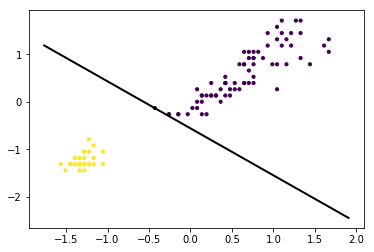

In [78]:
print(W,b)
# print(x_train_2['petal_length']) #x_train_2 may have 3 column. 0,;,1
print(x_train_1.columns[1])
# print(x_train_1[1,14,5])
# print(x_train_2[:,0])  is wrong?
import matplotlib.pyplot as plt
plot_x = np.array([np.min(x_train_1['petal_length'] - 0.2), np.max(x_train_1['petal_width']+0.2)])
plot_y = 1 / W[1] * (-W[0] * plot_x - b)

plt.scatter(x_train_1['petal_length'], x_train_1['petal_width'],c=np.squeeze(y_train_1), s=10, cmap='viridis')
plt.plot(plot_x, plot_y, color='k', linewidth=2)
# plt.xlim([-0.2, 1.2]); plt.ylim([-0.2, 1.25]);


The accuracy I am getting is that using this line as a classifier, What is the probability that data can be correctly classified.
It tell me the similarity between setosa and other two species. The more similar they are, the more difficultly they are distinguished, the lower the accuracy is. For setosa, the classifier can get good performance.

<h1>Part b:</h1>

In [79]:
x_2,y_2 = data_preprocessing(dataset,2,flower='Iris-virginica')
#generate traning and validation sets
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2,y_2,test_size=0.3)

Index(['petal_length', 'petal_width'], dtype='object')
species


<h2>Define hyper-parameter</h2>

In [80]:
lr = 0.01
num_steps = 500

<h2>Define Placeholder and Variables</h2>

In [81]:
tf.reset_default_graph()
#define the placeholder to feed the training data later
X = tf.placeholder(tf.float32,shape=[None,2],name='X')
Y = tf.placeholder(tf.float32,shape=[None,1],name='Y')

#define the weights and initialized with random normal distribution
W = tf.Variable(tf.random_normal([2,1]),tf.float32,name='W')
#define the bias with zero initialization
b = tf.Variable(tf.zeros([1,1]),tf.float32,name='b')

<h2>Define update rule and accuracy</h2>

In [82]:
#define the predicted output label
Y_hat = tf.round(tf.sigmoid(tf.add(tf.matmul(X,W),b)))
#the error between target and logit
error = Y-Y_hat

#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(X),error)
db = tf.reduce_sum(error,0)
W_ = W + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(W.assign(W_), b.assign(b_))

<h2>Execute training</h2>

In [83]:
#initialize tensorflow variables
init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  
#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)
    #training for number of iterations
    for i in range(500):
        #every iteration we run optimization on the training data X and labels Y
        sess.run(step,feed_dict = {X:x_train_2,Y:y_train_2})
    
    #after training, we acquire the weight and bias
    #np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    W = np.squeeze(sess.run(W))
    b = np.squeeze(sess.run(b))

<h2>Plot</h2>

[0.19769922 0.2334791 ] -0.23000044
petal_width


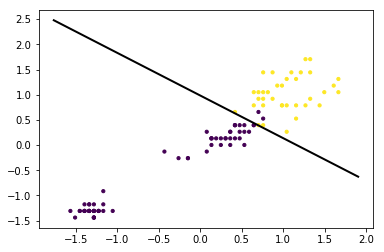

In [84]:
print(W,b)
# print(x_train_2['petal_length'])
print(x_train_2.columns[1])
# print(x_train_2[:,0])  is wrong?
import matplotlib.pyplot as plt
plot_x = np.array([np.min(x_train_2['petal_length'] - 0.2), np.max(x_train_2['petal_width']+0.2)])
plot_y = 1 / W[1] * (-W[0] * plot_x - b)

plt.scatter(x_train_2['petal_length'], x_train_2['petal_width'],c=np.squeeze(y_train_2), s=10, cmap='viridis')
plt.plot(plot_x, plot_y, color='k', linewidth=2)
# plt.xlim([-0.2, 1.2]); plt.ylim([-0.2, 1.25]);

The accuracy I am getting is that using this line as a classifier, What is the probability that data can be correctly classified.
It tell me the similarity between setosa and other two species. The more similar they are, the more difficultly they are distinguished, the lower the accuracy is. For virginica, the performance of the classifier is not good.

<h1>Part c:</h1>

In [126]:
x_3,y_3 = data_preprocessing(dataset,4)
#generate traning and validation sets
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3,y_3,test_size=0.3)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')
species


<h2>Define hyper-parameters</h2>

In [127]:
#learning rate
lr = 0.01
#number of traning steps
# num_steps =500


#network parameters
n_hidden_1 = 256
n_hidden_2 = 128
num_input = 4
num_classes = 3

<h2>Define placehoder and variables</h2>

In [128]:
tf.reset_default_graph()
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden_1]),name='W1'),
    'W2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]),name='W2'),
    'Wout': tf.Variable(tf.random_normal([n_hidden_2, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden_1]),name='b1'),
    'b2': tf.Variable(tf.zeros(shape=[n_hidden_2]),name='b2'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

<h2>Define the neural network</h2>

In [129]:
#define a neural net model
def neural_net(x):
    layer_1_out = tf.nn.relu(tf.add(tf.matmul(x,weights['W1']),biases['b1']))
    layer_2_out = tf.nn.relu(tf.add(tf.matmul(layer_1_out,weights['W2']),biases['b2']))
    out = tf.nn.softmax(tf.add(tf.matmul(layer_2_out,weights['Wout']),biases['bout']))
    return out

<h2>Define cost function and accuracy</h2>

In [130]:
#predicted labels
logits = neural_net(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
init = tf.global_variables_initializer()

<h2>Execute training</h2>

In [131]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(1):
        for i in range(num_steps):
        #run optimization
            sess.run(train_op, feed_dict={X:x_train_3, Y:y_train_3})
            if i % 100 ==0:
                acc = sess.run(accuracy,feed_dict={X:x_train_3, Y:y_train_3})
                print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
    
    print("Training finished!")
    
    print("Testing ACcuracy:", sess.run(accuracy, feed_dict={X:x_test_3, Y:y_test_3}))
    W = np.squeeze(sess.run(weights['Wout']))
    b = np.squeeze(sess.run(biases['bout']))
#     print(W,b)

step 0, Accuracy= 0.533
step 100, Accuracy= 0.543
step 200, Accuracy= 0.552
step 300, Accuracy= 0.552
step 400, Accuracy= 0.552
Training finished!
Testing ACcuracy: 0.46666667


<h2>Plot</h2>